In [1]:
import os

import h5py
import nibabel as nib
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
plt.style.use("dark_background")

from sklearn.model_selection import train_test_split
from scipy.ndimage import zoom

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2

import warnings
# Suppress specific OpenCV warnings about file reading
warnings.filterwarnings("ignore", message="global loadsave.cpp")
# Suppress all warnings
warnings.filterwarnings("ignore")
import logging
# Suppress specific OpenCV warnings about file reading
logging.getLogger('cv2').setLevel(logging.ERROR)
warnings.filterwarnings("ignore", message="findDecoder imread")

import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from skimage.transform import resize  # Assuming you use scikit-image for resizing



from keras.utils import Sequence
from keras.models import Sequential,load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import cv2  

2024-06-25 18:35:14.576587: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-25 18:35:14.576735: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-25 18:35:14.741150: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
!pip install timm einops ml_collections wget tensorboardX SimpleITK medpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 1.9 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.2/156.2 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 2.0 MB/s eta 0:00:00
  Created wheel for ml_collections: filename=ml_collections-0.1.1-py3-none-any.whl size=94507 sha256=50d1f7401a7239a63ceca6ff79b3661d88c22fc184820cc0761d74e41a64b717
  Stored in directory: /root/.cache/pip/wheels/7b/89/c9/a9b87790789e94aadcfc393c283e3ecd5ab916aed0a31be8fe
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=e6d6464672b44a3437eb36cdaade022ca433f27b7161a153e0cdb0eb57ff6c67
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
  Created wheel for medpy: filename=MedPy-0.5.1-py3-none-any.whl size=224731 sha256=2494ad8afeee41c6f9fa48

In [3]:
!pip install -U datasets trl accelerate peft bitsandbytes transformers trl huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 8.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.7/226.7 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 12.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 402.6/402.6 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.4/103.4 kB 6.8 MB/s eta 0:00:00
  Attempting uninstall: docstring-parser
    Found existing installation: docstring-parser 0.15
    Uninstalling docstring-parser-0.15:
      Successfully uninstalled docstring-parser-0.15
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.23.2
    Uninstalling huggingface-hub-0.23.2:
      Successfully uninstalled huggingface-hub-0.23.2
  Attempting uninstall: accelerate
 

In [4]:
!git clone "https://huggingface.co/Unknown6197/BEFUnet_Brats2020"

Cloning into 'BEFUnet_Brats2020'...
remote: Enumerating objects: 84, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 84 (delta 16), reused 0 (delta 0), pack-reused 3 (from 1)
Unpacking objects: 100% (84/84), 576.86 KiB | 5.77 MiB/s, done.
Filtering content: 100% (3/3), 270.02 MiB | 22.14 MiB/s, done.


In [6]:
!git clone https://huggingface.co/Unknown6197/res_classification

Cloning into 'res_classification'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 7 (delta 0), reused 0 (delta 0), pack-reused 3 (from 1)
Unpacking objects: 100% (7/7), 2.17 KiB | 1.08 MiB/s, done.


# **Segmentation Model**

In [7]:
#cd /kaggle/working/BEFUnet_Brats2020
import sys
sys.path.insert(1,'/kaggle/working/BEFUnet_Brats2020')

In [8]:
from datasets import dataset_synapse

db_train = dataset_synapse.Synapse_dataset(base_dir="/kaggle/input/brats2020-training-data/BraTS2020_training_data/content/data",
                                           list_dir="/kaggle/working/BEFUnet_Brats2020/lists",
                                           split="train",
                                           transform=v2.Compose([
                                               dataset_synapse.RandomGenerator(output_size=[224,224])
                                           ]))

db_test = dataset_synapse.Synapse_dataset(base_dir="/kaggle/input/brats2020-training-data/BraTS2020_training_data/content/data",
                                           list_dir="/kaggle/working/BEFUnet_Brats2020/lists",
                                           split="test_vol",
                                           transform=v2.Compose([
                                               dataset_synapse.transform_test(output_size=[224,224])
                                           ]))

train_loader = DataLoader(db_train, batch_size=5, shuffle=True)
test_loader = DataLoader(db_test, batch_size=1, shuffle=False)

In [9]:
for sample in train_loader:
    print('Train image shape ' , sample['image'].shape , ', label shape ' , sample['label'].shape, ', Number of Training Batches' , len(db_train)//5)
    break
for sample in test_loader:
    print('test image shape ' , sample['image'].shape , ', label shape ' , sample['label'].shape, ', Number of test Batches' , len(db_test))
    break

Train image shape  torch.Size([5, 1, 224, 224]) , label shape  torch.Size([5, 224, 224]) , Number of Training Batches 10078
test image shape  torch.Size([1, 1, 224, 224]) , label shape  torch.Size([1, 224, 224]) , Number of test Batches 509


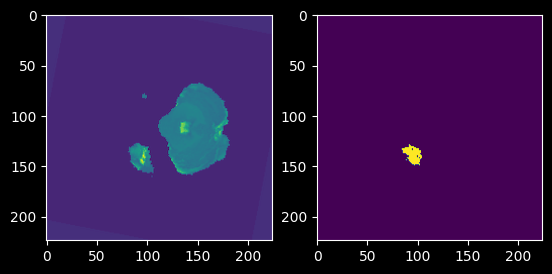

In [10]:
for sample in train_loader:
    img = sample["image"][:]
    mask = sample["label"][:]
    fig,axs = plt.subplots(1,2)
    axs[0].imshow(img[0].squeeze(0))
    axs[1].imshow(mask[0])
    break

# **Model**

In [49]:
from configs.BEFUnet_configs import get_BEFUnet_configs
from models.BEFUnet import BEFUnet

cfg = get_BEFUnet_configs()
model = BEFUnet(cfg,n_classes=3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

{'layer0': 'cd', 'layer1': 'ad', 'layer2': 'rd', 'layer3': 'cv', 'layer4': 'cd', 'layer5': 'ad', 'layer6': 'rd', 'layer7': 'cv', 'layer8': 'cd', 'layer9': 'ad', 'layer10': 'rd', 'layer11': 'cv', 'layer12': 'cd', 'layer13': 'ad', 'layer14': 'rd', 'layer15': 'cv'}
initialization done


BEFUnet(
  (All2Cross): All2Cross(
    (pyramid): PyramidFeatures(
      (swin_transformer): SwinTransformer(
        (pos_drop): Dropout(p=0.0, inplace=False)
        (layers): ModuleList(
          (0): BasicLayer(
            dim=96, input_resolution=(56, 56), depth=2
            (blocks): ModuleList(
              (0): SwinTransformerBlock(
                dim=96, input_resolution=(56, 56), num_heads=3, window_size=7, shift_size=0, mlp_ratio=4.0
                (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
                (attn): WindowAttention(
                  dim=96, window_size=(7, 7), num_heads=3
                  (qkv): Linear(in_features=96, out_features=288, bias=True)
                  (attn_drop): Dropout(p=0.0, inplace=False)
                  (proj): Linear(in_features=96, out_features=96, bias=True)
                  (proj_drop): Dropout(p=0.0, inplace=False)
                  (softmax): Softmax(dim=-1)
                )
                (drop_path): I

In [50]:
from utils import DiceLoss
epochs = 10
lr = 0.001
dice_loss = DiceLoss(3)
ce_loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr,weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

In [13]:
def train_model(model,train_loader,epochs,lr,device):
    model.train()
    for epoch in range(epochs):
        running_loss = 0
        print(f"epoch {epoch+1}",end=' ')
        for batch in tqdm(train_loader):
            image_batch, label_batch = batch['image'], batch['label']
            image_batch, label_batch = image_batch.to(device), label_batch.to(device)

            B, C, H, W = image_batch.shape
            image_batch = image_batch.expand(B, 3, H, W)
            
            outputs = model(image_batch)
            
            loss_ce = ce_loss(outputs, label_batch[:].long())
            loss_dice = dice_loss(outputs, label_batch, softmax=True)
            loss = 0.4 * loss_ce + 0.6 * loss_dice
            
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()  
            running_loss += loss.item()
            
        scheduler.step()
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")
        torch.save(model.state_dict(), f'/kaggle/working/model_weights{epoch+1}.pth')
        print("Weights Saving done!")
        torch.save(scheduler.state_dict(), f'/kaggle/working/scheduler_epoch_{epoch+1}.pth')
        print("Scheduler Saved")

In [ ]:
train_model(model,train_loader,epochs,lr,device)

In [51]:
# Load the weights into a dictionary
weights_path = '/kaggle/working/BEFUnet_Brats2020/weights/model_weights_brats_9_Adam.pth'
weights_dict = torch.load(weights_path, map_location=torch.device(device))
# Load the weights into your model
model.load_state_dict(weights_dict)

<All keys matched successfully>

In [15]:
def calculate_miou(mask, seg_pred):
    
    mask = mask.detach().numpy()
    
    seg_pred = seg_pred.detach().numpy()
    seg_pred = seg_pred.squeeze(0)
    
    intersection = np.logical_and(mask, seg_pred)
    union = np.logical_or(mask, seg_pred)

    # Calculate IoU
    if np.sum(union) == 0:
        return 1 if np.sum(intersection) == 0 else 0
    else:
        # Calculate IoU
        iou = np.sum(intersection) / np.sum(union)
        return iou

def calculate_dice_loss(mask, seg_pred):
    mask = mask.detach().numpy()

    seg_pred = seg_pred.detach().numpy()
    seg_pred = seg_pred.squeeze(0)

    # Calculate Intersection
    intersection = np.sum(mask * seg_pred)

    # Calculate Dice loss
    dice_loss = 1 - ((2. * intersection + 1e-6) / (np.sum(mask) + np.sum(seg_pred) + 1e-6))

    return dice_loss


def calculate_precision(mask, seg_pred):
    mask = mask.detach().numpy()
    seg_pred = seg_pred.detach().numpy()
    seg_pred = seg_pred.squeeze(0)

    # Calculate True Positives (TP) and False Positives (FP)
    TP = np.sum((seg_pred == 1) & (mask == 1))
    FP = np.sum((seg_pred == 1) & (mask == 0))

    # Calculate Precision
    precision = TP / (TP + FP + 1e-6)

    return precision

def calculate_recall(mask, seg_pred):
    mask = mask.detach().numpy()
    seg_pred = seg_pred.detach().numpy()
    seg_pred = seg_pred.squeeze(0)

    # Calculate True Positives (TP) and False Negatives (FN)
    TP = np.sum((seg_pred == 1) & (mask == 1))
    FN = np.sum((seg_pred == 0) & (mask == 1))

    # Calculate Recall
    recall = TP / (TP + FN + 1e-6)

    return recall

def calculate_f1_score(mask, seg_pred):
    mask = mask.detach().numpy()
    seg_pred = seg_pred.detach().numpy()
    seg_pred = seg_pred.squeeze(0)

    # Calculate True Positives (TP), False Positives (FP), and False Negatives (FN)
    TP = np.sum((seg_pred == 1) & (mask == 1))
    FP = np.sum((seg_pred == 1) & (mask == 0))
    FN = np.sum((seg_pred == 0) & (mask == 1))

    # Calculate Precision and Recall
    precision = TP / (TP + FP + 1e-6)
    recall = TP / (TP + FN + 1e-6)

    # Calculate F1 score
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-6)

    return f1_score


Print 10 test samples


  0%|          | 0/509 [00:00<?, ?it/s]

Batch 1


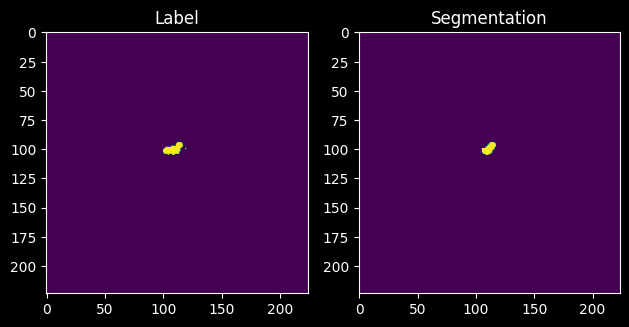

Batch 2


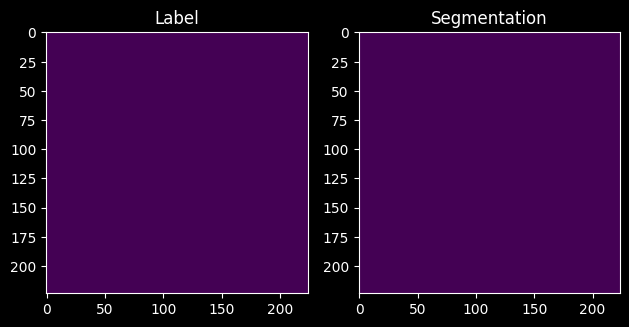

Batch 3


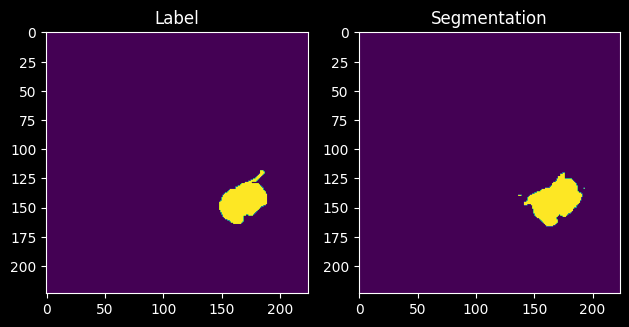

Batch 4


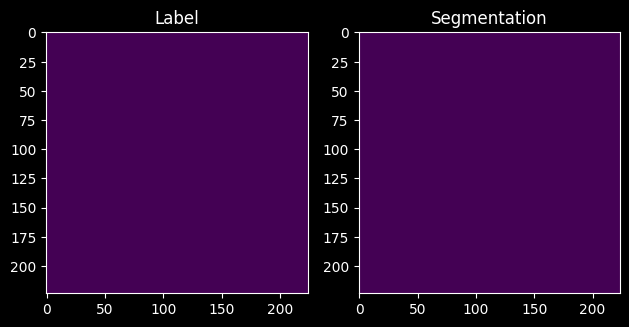

Batch 5


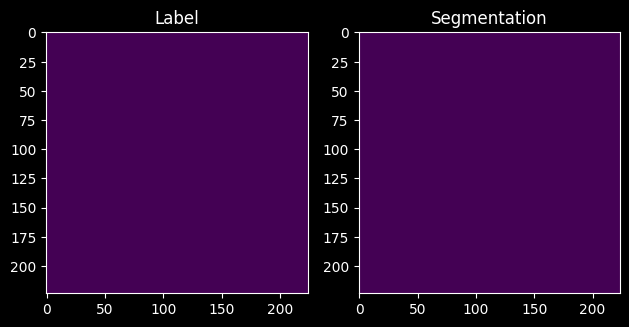

Batch 6


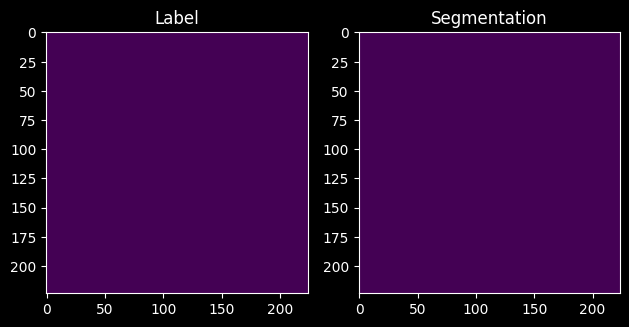

Batch 7


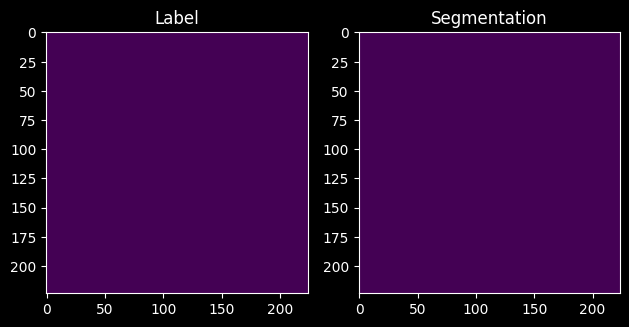

Batch 8


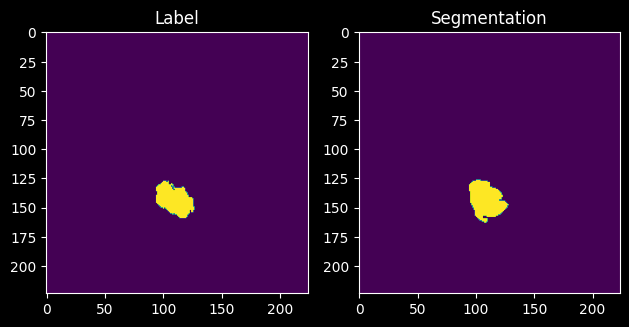

Batch 9


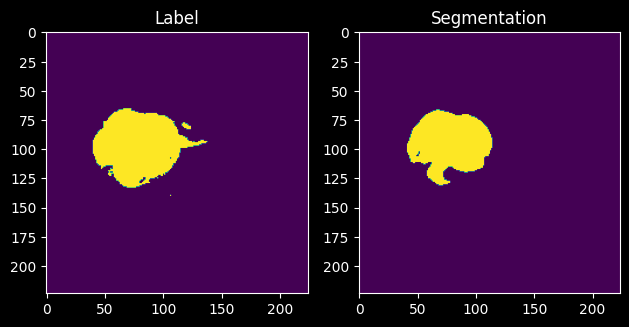

Batch 10


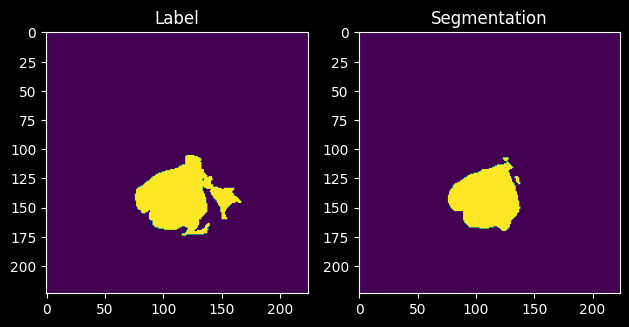

Total Avg_MIoU : 0.8051742487800382
Total Avg_Dice_Coef : 0.15425151207497362
Total Avg_Precision : 0.39324135444432534
Total Avg_Recall : 0.3354905036345437
 Total Avg_F1_Score : 0.3526245019876574


In [20]:
model.eval()
model.to('cpu')
count = 0

avg_miou = []
avg_dice_coef = []
avg_accuracy = []
avg_precision = []
avg_recall = []
avg_F1 = []

print("Print 10 test samples")
for sample in tqdm(test_loader):
    img, label = sample['image'], sample['label']
    
    image_batch, label_batch = img.to('cpu'), label.to('cpu')

    B, C, H, W = image_batch.shape
    image_batch = image_batch.expand(B, 3, H, W)
    
    outputs = model(image_batch)
    outputs = torch.argmax(torch.softmax(outputs, dim=1), dim=1, keepdim=True)

    avg_miou.append(calculate_miou(label_batch,outputs))
    avg_dice_coef.append(calculate_dice_loss(label_batch,outputs))
    avg_precision.append(calculate_precision(label_batch,outputs))
    avg_recall.append(calculate_recall(label_batch,outputs))
    avg_F1.append(calculate_f1_score(label_batch,outputs))
       
    
 
    if count < 10:
        print(f'Batch {count+1}')
        fig,axs = plt.subplots(1,2)
        axs[0].imshow(label[0].squeeze(0))
        axs[0].set_title('Label')
        axs[1].imshow(outputs[0].squeeze(0))
        axs[1].set_title('Segmentation')
        plt.tight_layout()
        plt.show()
    else:
        continue   
        
    count+= 1
    
print(f'Total Avg_MIoU : {sum(avg_miou)/len(test_loader)}\nTotal Avg_Dice_Coef : {sum(avg_dice_coef)/len(test_loader)}')
print(f"Total Avg_Precision : {sum(avg_precision)/len(test_loader)}")
print(f"Total Avg_Recall : {sum(avg_recall)/len(test_loader)}\n Total Avg_F1_Score : {sum(avg_F1)/len(test_loader)}")

# **Inference Class**

In [52]:
class predictor_h5(nn.Module):
    def __init__(self,model,output_size):
        super().__init__()
        self.model = model.eval()
        self.output_size = output_size
        
    def forward(self,x):
        img, label = x['image'][:], x['mask'][:]

        image, label = np.max(img,axis = -1), np.max(label,axis = -1)

        h, w = image.shape

        if h != self.output_size[0] or w != self.output_size[1]:
            image = zoom(image, (self.output_size[0] / h, self.output_size[1] / w), order=3)  # why not 3?
            label = zoom(label, (self.output_size[0] / h, self.output_size[1] / w), order=0)

        image = torch.from_numpy(image.astype(np.float32)).unsqueeze(0)
        label = torch.from_numpy(label.astype(np.float32)).long()


        image = image.expand(1,3,image.shape[1],image.shape[2])

        # forward path for image
        x = self.model(image)
        # give probability to each output class torch.argmax(torch.softmax(outputs, dim=1), dim=1, keepdim=True)
        x = torch.softmax(x,dim=1)
        # choose the class with the highest probability
        x = torch.argmax(x,dim=1,keepdim=True)
        
        return x

In [17]:
path = "/kaggle/input/brats2020-training-data/BraTS2020_training_data/content/data/volume_91_slice_83.h5"
output_size = (224,224)

data = h5py.File(path)

In [18]:
img, label = data['image'][:], data['mask'][:]

image, label = np.max(img,axis = -1), np.max(label,axis = -1)

h, w = image.shape

if h != output_size[0] or w != output_size[1]:
    image = zoom(image, (output_size[0] / h, output_size[1] / w), order=3)  # why not 3?
    label = zoom(label, (output_size[0] / h, output_size[1] / w), order=0)

image = torch.from_numpy(image.astype(np.float32)).unsqueeze(0)
label = torch.from_numpy(label.astype(np.float32)).long()


image = image.expand(1,3,image.shape[1],image.shape[2])

In [19]:
pred = predictor_h5(model,(224,224))
output = pred.forward(data)

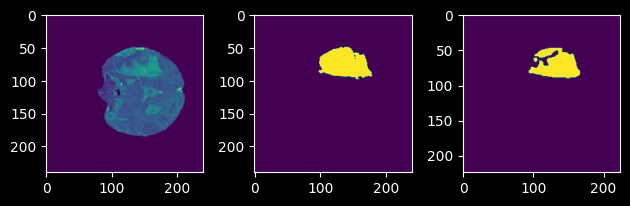

In [20]:
fig,axs = plt.subplots(1,3)
axs[0].imshow(np.max(data['image'][:],-1))
axs[1].imshow(np.max(data['mask'][:],-1))
axs[2].imshow(output[0].squeeze(0))
plt.tight_layout()
plt.show()